In [44]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
import copy
import requests
from concurrent.futures import ThreadPoolExecutor

from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from pypfopt.expected_returns import ema_historical_return, capm_return
from pypfopt.risk_models import exp_cov, fix_nonpositive_semidefinite, CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions
from pypfopt import base_optimizer
import optuna

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import utils as ut

## Global Settings

In [2]:
seed = 1227
rs = np.random.RandomState(seed)

mpl.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)

warnings.filterwarnings('ignore')

## Data

In [3]:
in_sample_data = pd.read_parquet('../data/in_sample_data.parquet')
out_sample_data = pd.read_parquet('../data/out_sample_data.parquet')
sp_500 = pd.read_csv('../data/sp_500.csv', index_col=0)

in_sample_data.shape, out_sample_data.shape, sp_500.shape

((1259, 30), (332, 30), (1259, 1))

We create a dictionary of ticker-sector key value pairs for use later when we add sector constraints:

In [4]:
# Sector mappings
nasdaq_obj = ut.Nasdaq100(in_sample_data.columns.tolist())
sector_mappings = {ticker: sector for ticker, sector in zip(nasdaq_obj.tickers, nasdaq_obj.get_industries())}
sector_mappings

{'AAPL': 'Technology',
 'AMZN': 'Retail',
 'BIIB': 'Healthcare',
 'CMCSA': 'Telecom',
 'CME': 'Financial Services',
 'COST': 'Retail',
 'CSCO': 'Technology',
 'EA': 'Technology',
 'EBAY': 'Retail',
 'GOOG': 'Technology',
 'HD': 'Retail',
 'HON': 'Manufacturing',
 'INTC': 'Technology',
 'JPM': 'Financial Services',
 'LULU': 'Retail',
 'META': 'Technology',
 'MSFT': 'Technology',
 'NFLX': 'Media & Entertainment',
 'NVDA': 'Technology',
 'ORLY': 'Consumer Discretionary',
 'PEP': 'Consumer Staples',
 'PFE': 'Healthcare',
 'PYPL': 'Technology',
 'QCOM': 'Technology',
 'SBUX': 'Consumer Discretionary',
 'TSLA': 'Consumer Discretionary',
 'TXN': 'Technology',
 'VRTX': 'Healthcare',
 'WDAY': 'Technology',
 'XEL': 'Utilities'}

## Objective Function 

The objective function will allow us to select different combinations of strategies and select the one that performs the best based on a performance metric on the out sample data (past 16 months). The metric we will optimize (maximize) is the sharpe ratio of the portfolio given the following inputs:

* Optimal weights of the optimization model

* Out sample expected returns

* Out sample covariance matrix estimator

* Risk free rate, which is interpolated from the yield curve as follows:

In [5]:
# Child 4 indicates the row of the table corresponding to the most recent day, e.g., 2023-03-06 
# See https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve
selectors = [
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(4) > td.bc1month.views-field.views-field-field-bc-1month',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(4) > td.bc2month.views-field.views-field-field-bc-2month',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(4) > td.bc3month.views-field.views-field-field-bc-3month',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(4) > td.bc4month.views-field.views-field-field-bc-4month',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(4) > td.views-field.views-field-field-bc-6month',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(4) > td.views-field.views-field-field-bc-1year',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(4) > td.views-field.views-field-field-bc-2year',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(4) > td.bc3month.views-field.views-field-field-bc-3year',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(4) > td.views-field.views-field-field-bc-5year',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(4) > td.views-field.views-field-field-bc-7year',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(4) > td.views-field.views-field-field-bc-10year',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(4) > td.bc20year.views-field.views-field-field-bc-20year',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(4) > td.bc30year.views-field.views-field-field-bc-30year'
]

# Function to scrape the yield curve from the treasury.gov website
def get_yield_curve(selector: str) -> float:
    """
    Parameters
    ----------
    selector : str
        A CSS selector string for the yield curve data for a given maturity and date.

    Returns
    -------
    float
        A yield curve value for a given maturity.
    """
    url = 'https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value_month=202303'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    element = soup.select_one(selector)
    
    return float(element.text.strip()) # Remove leading and trailing whitespace and convert rate to float

with ThreadPoolExecutor() as executor: # Use all available cores
    results = list(executor.map(get_yield_curve, selectors))

Now, we interpolate the 16 month constant maturity rate using cubic interpolation:

In [6]:
# Rates and maturities are in the same order
rates = np.array(results)
maturities = np.array([1/12, 2/12, 3/12, 4/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])

# Create an interpolation function using cubic interpolation
f = interp1d(maturities, rates, kind='cubic')

# Interpolate the 16-month rate
rate_16m = float(f(16/12))

print("Interpolated 16-month rate:", rate_16m)

Interpolated 16-month rate: 4.907758787530469


We can plot the yield curve using cubic spline:

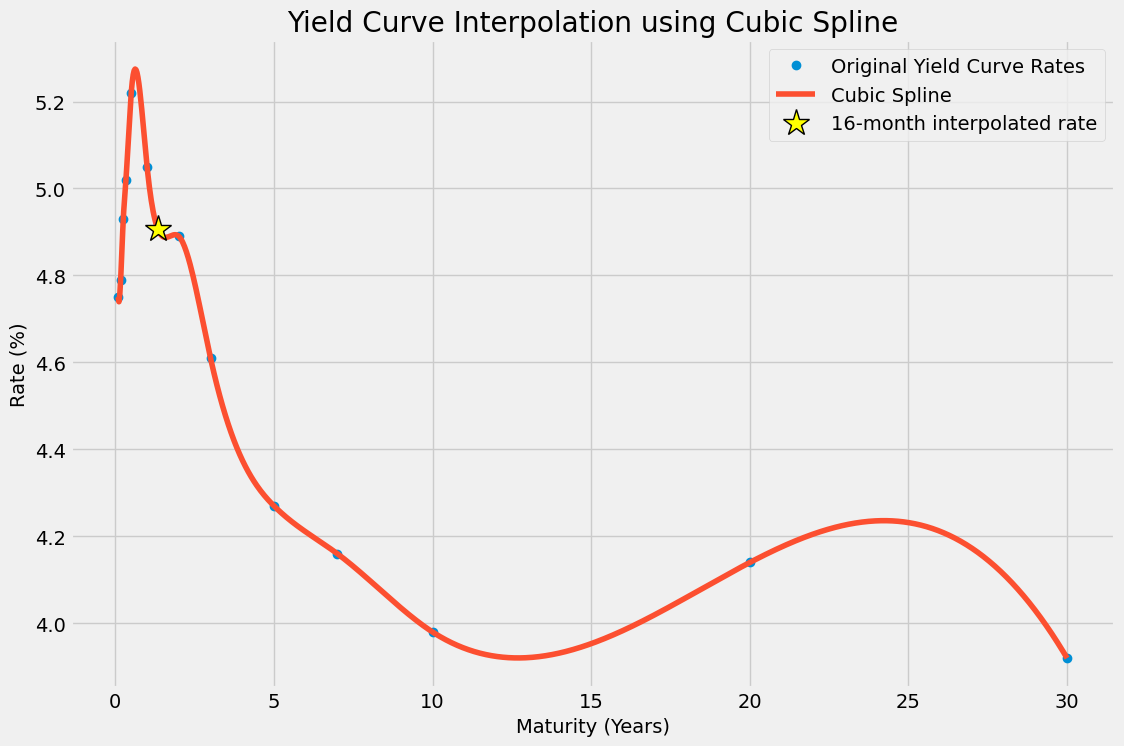

In [7]:
plt.plot(maturities, rates, 'o', label='Original Yield Curve Rates') # Using 'o' (circle marker) to denote the original data points

# Plot the interpolated yield curve using cubic spline
maturities_cubic_spline = np.linspace(maturities.min(), maturities.max(), 1000)
rates_cubic_spline = f(maturities_cubic_spline)
plt.plot(maturities_cubic_spline , rates_cubic_spline, '-', label='Cubic Spline') # Using '-' (solid line) to denote the interpolated data points

# Plot the 16-month interpolated rate
plt.plot(16/12, rate_16m, '*', label='16-month interpolated rate', markersize=20, markerfacecolor='yellow', markeredgecolor='black')

plt.title('Yield Curve Interpolation using Cubic Spline')
plt.xlabel('Maturity (Years)')
plt.ylabel('Rate (%)')
plt.legend()

# display the plot
plt.show();

In [8]:
rate_16m /= 100

Now, we can write our objective function:

In [18]:
def objective(trial):
    
    # -------------------------- Initial hyperparameters ------------------------- #
    
    params = {
        'expected_return_model': trial.suggest_categorical('expected_return_model', ['capm', 'exp_weighted']),
        'risk_model': trial.suggest_categorical('risk_model', ['exp_weighted', 'shrinkage']),
        'reg_gamma': trial.suggest_int('reg_gamma', 1, 3)
    }
    
    # ------------------------------- Returns model ------------------------------ #
    
    # If the expected return model is capm, then we need to specify the risk free rate
    if params['expected_return_model'] == 'capm':
        
        in_sample_returns = capm_return(
            prices=in_sample_data,
            returns_data=False,
            risk_free_rate=rate_16m / 100
        )
        
        out_sample_returns = capm_return(
            prices=out_sample_data,
            returns_data=False,
            risk_free_rate=rate_16m
        )
    else:
        # If the expected return model is exp_weighted, then we need to specify the 'span' parameter for the exponential moving average
        params['returns_span'] = trial.suggest_int('returns_span', 200, 700)
        
        in_sample_returns = ema_historical_return(
            prices=in_sample_data,
            span=params['returns_span'],
            returns_data=False,
            frequency=252,
            compounding=True
        )
        
        out_sample_returns = ema_historical_return(
            prices=out_sample_data,
            span=params['returns_span'],
            returns_data=False,
            frequency=252,
            compounding=True
        )

    # -------------------------------- Risk model -------------------------------- #
    
    # If the risk model is shrinkage, then we need to specify the shrinkage target
    if params['risk_model'] == 'shrinkage':
        
        params['shrinkage_target'] = trial.suggest_categorical('shrinkage_target', ['constant_variance', 'single_factor', 'constant_correlation'])
        
        in_sample_shrinkage_model = CovarianceShrinkage(prices=in_sample_data, returns_data=False, frequency=252)
        out_sample_shrinkage_model = CovarianceShrinkage(prices=out_sample_data, returns_data=False, frequency=252)
        
        in_sample_cov = in_sample_shrinkage_model.ledoit_wolf(params['shrinkage_target'])
        out_sample_cov = out_sample_shrinkage_model.ledoit_wolf(params['shrinkage_target'])
        
        # Check for positive semi-definiteness
        in_sample_cov = fix_nonpositive_semidefinite(in_sample_cov)
        out_sample_cov = fix_nonpositive_semidefinite(out_sample_cov)
        
    else: 
        # If the risk model is exp_weighted, then we need to specify the 'span' parameter for the exponential moving average
        # This allows us to use different spans for the returns and covariance matrices
        params['cov_span'] = trial.suggest_int('cov_span', 200, 700)
        
        in_sample_cov = exp_cov(
            prices=in_sample_data,
            returns_data=False,
            span=params['cov_span'],
            frequency=252
        )
        
        out_sample_cov = exp_cov(
            prices=out_sample_data,
            returns_data=False,
            span=params['cov_span'],
            frequency=252
        )
        
        # Check for positive semi-definiteness
        in_sample_cov = fix_nonpositive_semidefinite(in_sample_cov)
        out_sample_cov = fix_nonpositive_semidefinite(out_sample_cov)
        
    # ------------------------------- Optimization ------------------------------- #
    
    # Create the optimization model
    markowitz_model = EfficientFrontier(
        expected_returns=in_sample_returns.to_numpy().flatten(),
        cov_matrix=in_sample_cov,
        weight_bounds=(0, 1), # Assume fully invested portfolio
        solver=None # Use cvxpy’s default choice of solver
    )
    
    # Add sector constraints (the sector_mappings dictionary is scoped from the enclosing environment)
    markowitz_model.add_sector_constraints(
        sector_mapper=sector_mappings, 
        sector_lower={'Technology': 0.1}, # At least 10% of the portfolio should be invested in the Technology sector
        sector_upper={'Technology': 0.3} # At most 30% of the portfolio should be invested in the Technology sector
    )
    
    # Add the regularization term (tuning gamma i.e., the higher the value of gamma, the more non-negligible weights)
    markowitz_model.add_objective(objective_functions.L2_reg, gamma=params['reg_gamma'])
    
    optimal_weights = markowitz_model.max_sharpe(risk_free_rate=rate_16m)
    
    # -------------------------------- Evaluation -------------------------------- #
    
    # Out of sample performance
    negated_out_sample_sharpe = objective_functions.sharpe_ratio(
        w=np.array(list(optimal_weights.values())), 
        expected_returns=out_sample_returns.to_numpy().flatten(), 
        cov_matrix=out_sample_cov, 
        risk_free_rate=rate_16m,
        negative=True # Calculate the negative sharpe ratio, so we can minimize the optuna objective function
    )
    
    print('Out of sample sharpe ratio: {}'.format(negated_out_sample_sharpe))
    
    return negated_out_sample_sharpe

In [19]:
# Create the study object
study = optuna.create_study(
    sampler=optuna.samplers.TPESampler(), 
    study_name='min_neg_sharpe', 
    direction='minimize', 
    pruner=optuna.pruners.HyperbandPruner() # Prune unpromising trials
)
study.optimize(objective, n_trials=100, n_jobs=-1)

[I 2023-03-07 03:40:26,899] A new study created in memory with name: min_neg_sharpe
[I 2023-03-07 03:40:28,034] Trial 2 finished with value: 0.7110448281034156 and parameters: {'expected_return_model': 'capm', 'risk_model': 'shrinkage', 'reg_gamma': 2, 'shrinkage_target': 'constant_correlation'}. Best is trial 2 with value: 0.7110448281034156.


Out of sample sharpe ratio: 0.7110448281034156


[I 2023-03-07 03:40:28,526] Trial 0 finished with value: 0.7078872208527056 and parameters: {'expected_return_model': 'capm', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'shrinkage_target': 'single_factor'}. Best is trial 0 with value: 0.7078872208527056.


Out of sample sharpe ratio: 0.7078872208527056


[I 2023-03-07 03:40:28,758] Trial 7 finished with value: 0.1716316728878896 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 2, 'returns_span': 545, 'shrinkage_target': 'constant_variance'}. Best is trial 7 with value: 0.1716316728878896.


Out of sample sharpe ratio: 0.1716316728878896


[I 2023-03-07 03:40:30,614] Trial 4 finished with value: 0.733993501601246 and parameters: {'expected_return_model': 'capm', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'cov_span': 265}. Best is trial 7 with value: 0.1716316728878896.
[I 2023-03-07 03:40:30,757] Trial 3 finished with value: 0.7142924299575362 and parameters: {'expected_return_model': 'capm', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'cov_span': 681}. Best is trial 7 with value: 0.1716316728878896.


Out of sample sharpe ratio: 0.733993501601246
Out of sample sharpe ratio: 0.7142924299575362


[I 2023-03-07 03:40:30,974] Trial 1 finished with value: 0.7252949511152086 and parameters: {'expected_return_model': 'capm', 'risk_model': 'exp_weighted', 'reg_gamma': 2, 'cov_span': 341}. Best is trial 7 with value: 0.1716316728878896.
[I 2023-03-07 03:40:31,010] Trial 9 finished with value: 0.7195783853848104 and parameters: {'expected_return_model': 'capm', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'shrinkage_target': 'constant_variance'}. Best is trial 7 with value: 0.1716316728878896.
[I 2023-03-07 03:40:31,040] Trial 6 finished with value: 0.7220234893587498 and parameters: {'expected_return_model': 'capm', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'cov_span': 387}. Best is trial 7 with value: 0.1716316728878896.
[I 2023-03-07 03:40:31,134] Trial 10 finished with value: -0.08371470660747163 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 3, 'returns_span': 341, 'shrinkage_target': 'constant_correlation'}. Best is trial 10 wi

Out of sample sharpe ratio: 0.7252949511152086
Out of sample sharpe ratio: 0.7195783853848104
Out of sample sharpe ratio: 0.7220234893587498
Out of sample sharpe ratio: -0.08371470660747163


[I 2023-03-07 03:40:31,212] Trial 5 finished with value: 0.08012069607897099 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 1, 'returns_span': 467, 'cov_span': 544}. Best is trial 10 with value: -0.08371470660747163.


Out of sample sharpe ratio: 0.08012069607897099


[I 2023-03-07 03:40:32,093] Trial 8 finished with value: 0.10101540596835104 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 2, 'returns_span': 466, 'cov_span': 321}. Best is trial 10 with value: -0.08371470660747163.
[I 2023-03-07 03:40:32,200] Trial 11 finished with value: 0.25705147646209875 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 3, 'returns_span': 698, 'shrinkage_target': 'single_factor'}. Best is trial 10 with value: -0.08371470660747163.


Out of sample sharpe ratio: 0.10101540596835104
Out of sample sharpe ratio: 0.25705147646209875


[I 2023-03-07 03:40:33,152] Trial 12 finished with value: 0.7077995946673964 and parameters: {'expected_return_model': 'capm', 'risk_model': 'shrinkage', 'reg_gamma': 3, 'shrinkage_target': 'single_factor'}. Best is trial 10 with value: -0.08371470660747163.
[I 2023-03-07 03:40:33,193] Trial 14 finished with value: 0.7077995946673964 and parameters: {'expected_return_model': 'capm', 'risk_model': 'shrinkage', 'reg_gamma': 3, 'shrinkage_target': 'single_factor'}. Best is trial 10 with value: -0.08371470660747163.
[I 2023-03-07 03:40:33,236] Trial 17 finished with value: -0.5275065093547407 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 3, 'returns_span': 223, 'shrinkage_target': 'constant_correlation'}. Best is trial 17 with value: -0.5275065093547407.


Out of sample sharpe ratio: 0.7077995946673964
Out of sample sharpe ratio: 0.7077995946673964
Out of sample sharpe ratio: -0.5275065093547407


[I 2023-03-07 03:40:33,842] Trial 13 finished with value: 0.7165782139718893 and parameters: {'expected_return_model': 'capm', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'cov_span': 537}. Best is trial 17 with value: -0.5275065093547407.
[I 2023-03-07 03:40:33,933] Trial 15 finished with value: 0.7237379130326603 and parameters: {'expected_return_model': 'capm', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'cov_span': 360}. Best is trial 17 with value: -0.5275065093547407.


Out of sample sharpe ratio: 0.7165782139718893
Out of sample sharpe ratio: 0.7237379130326603


[I 2023-03-07 03:40:34,240] Trial 16 finished with value: 0.17855720562784605 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 2, 'returns_span': 563, 'cov_span': 526}. Best is trial 17 with value: -0.5275065093547407.
[I 2023-03-07 03:40:34,341] Trial 18 finished with value: -0.45227518880147816 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 243, 'shrinkage_target': 'constant_correlation'}. Best is trial 17 with value: -0.5275065093547407.


Out of sample sharpe ratio: 0.17855720562784605
Out of sample sharpe ratio: -0.45227518880147816


[I 2023-03-07 03:40:34,457] Trial 19 finished with value: -0.4576804538684845 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 242, 'shrinkage_target': 'constant_correlation'}. Best is trial 17 with value: -0.5275065093547407.
[I 2023-03-07 03:40:34,528] Trial 22 finished with value: -0.6883330345120647 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 3, 'returns_span': 200, 'shrinkage_target': 'constant_correlation'}. Best is trial 22 with value: -0.6883330345120647.


Out of sample sharpe ratio: -0.4576804538684845
Out of sample sharpe ratio: -0.6883330345120647


[I 2023-03-07 03:40:34,927] Trial 23 finished with value: -0.5488599753511045 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 2, 'returns_span': 222, 'shrinkage_target': 'constant_correlation'}. Best is trial 22 with value: -0.6883330345120647.
[I 2023-03-07 03:40:34,994] Trial 24 finished with value: -0.6823403694536272 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 2, 'returns_span': 203, 'shrinkage_target': 'constant_correlation'}. Best is trial 22 with value: -0.6883330345120647.
[I 2023-03-07 03:40:35,070] Trial 20 finished with value: -0.50927909400037 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 1, 'returns_span': 238, 'cov_span': 521}. Best is trial 22 with value: -0.6883330345120647.
[I 2023-03-07 03:40:35,095] Trial 25 finished with value: -0.6726662840279874 and parameters: {'expected_return_model': 'exp_weighted', 'risk

Out of sample sharpe ratio: -0.5488599753511045
Out of sample sharpe ratio: -0.6823403694536272
Out of sample sharpe ratio: -0.50927909400037
Out of sample sharpe ratio: -0.6726662840279874


[I 2023-03-07 03:40:35,137] Trial 28 finished with value: -0.6298732936825964 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 2, 'returns_span': 210, 'shrinkage_target': 'constant_correlation'}. Best is trial 22 with value: -0.6883330345120647.
[I 2023-03-07 03:40:35,227] Trial 26 finished with value: -0.6794078970307881 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 208, 'shrinkage_target': 'constant_correlation'}. Best is trial 22 with value: -0.6883330345120647.
[I 2023-03-07 03:40:35,291] Trial 21 finished with value: -0.5332589073167696 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 1, 'returns_span': 234, 'cov_span': 531}. Best is trial 22 with value: -0.6883330345120647.
[I 2023-03-07 03:40:35,319] Trial 27 finished with value: -0.6414756275553299 and parameters: {'expected_return_model': 'exp_weighted', 'ri

Out of sample sharpe ratio: -0.6298732936825964
Out of sample sharpe ratio: -0.6794078970307881
Out of sample sharpe ratio: -0.5332589073167696
Out of sample sharpe ratio: -0.6414756275553299


[I 2023-03-07 03:40:35,424] Trial 29 finished with value: -0.6371181092478708 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 2, 'returns_span': 209, 'shrinkage_target': 'constant_correlation'}. Best is trial 22 with value: -0.6883330345120647.
[I 2023-03-07 03:40:35,537] Trial 34 finished with value: -0.1100302774703237 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 2, 'returns_span': 333, 'shrinkage_target': 'constant_correlation'}. Best is trial 22 with value: -0.6883330345120647.
[I 2023-03-07 03:40:35,560] Trial 30 finished with value: -0.16765958776919634 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 2, 'returns_span': 311, 'shrinkage_target': 'constant_correlation'}. Best is trial 22 with value: -0.6883330345120647.


Out of sample sharpe ratio: -0.6371181092478708
Out of sample sharpe ratio: -0.1100302774703237
Out of sample sharpe ratio: -0.16765958776919634


[I 2023-03-07 03:40:35,649] Trial 36 finished with value: -0.12228862953571376 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 2, 'returns_span': 328, 'shrinkage_target': 'constant_correlation'}. Best is trial 22 with value: -0.6883330345120647.
[I 2023-03-07 03:40:35,807] Trial 31 finished with value: -0.14556216016294576 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 2, 'returns_span': 319, 'shrinkage_target': 'constant_correlation'}. Best is trial 22 with value: -0.6883330345120647.
[I 2023-03-07 03:40:35,809] Trial 33 finished with value: -0.10763321581922149 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 2, 'returns_span': 334, 'shrinkage_target': 'constant_correlation'}. Best is trial 22 with value: -0.6883330345120647.
[I 2023-03-07 03:40:35,816] Trial 32 finished with value: -0.12479624421924906 and parameters: {'expected_return

Out of sample sharpe ratio: -0.12228862953571376
Out of sample sharpe ratio: -0.14556216016294576
Out of sample sharpe ratio: -0.10763321581922149
Out of sample sharpe ratio: -0.12479624421924906


[I 2023-03-07 03:40:36,037] Trial 35 finished with value: -0.12732296386127867 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 2, 'returns_span': 326, 'shrinkage_target': 'constant_correlation'}. Best is trial 22 with value: -0.6883330345120647.
[I 2023-03-07 03:40:36,206] Trial 37 finished with value: -0.18626743164341641 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 2, 'returns_span': 305, 'shrinkage_target': 'constant_variance'}. Best is trial 22 with value: -0.6883330345120647.


Out of sample sharpe ratio: -0.12732296386127867
Out of sample sharpe ratio: -0.18626743164341641


[I 2023-03-07 03:40:36,285] Trial 38 finished with value: -0.21608563055820978 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 3, 'returns_span': 292, 'shrinkage_target': 'constant_correlation'}. Best is trial 22 with value: -0.6883330345120647.
[I 2023-03-07 03:40:36,335] Trial 39 finished with value: -0.22741863432637574 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 3, 'returns_span': 289, 'shrinkage_target': 'constant_variance'}. Best is trial 22 with value: -0.6883330345120647.
[I 2023-03-07 03:40:36,362] Trial 40 finished with value: -0.32549954854878665 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 3, 'returns_span': 263, 'shrinkage_target': 'constant_variance'}. Best is trial 22 with value: -0.6883330345120647.
[I 2023-03-07 03:40:36,464] Trial 43 finished with value: -0.23763888390666216 and parameters: {'expected_return_model

Out of sample sharpe ratio: -0.21608563055820978
Out of sample sharpe ratio: -0.22741863432637574
Out of sample sharpe ratio: -0.32549954854878665
Out of sample sharpe ratio: -0.23763888390666216


[I 2023-03-07 03:40:36,520] Trial 41 finished with value: -0.2850989323616494 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 3, 'returns_span': 273, 'shrinkage_target': 'constant_variance'}. Best is trial 22 with value: -0.6883330345120647.
[I 2023-03-07 03:40:36,599] Trial 42 finished with value: -0.26620826698351213 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 3, 'returns_span': 278, 'shrinkage_target': 'constant_variance'}. Best is trial 22 with value: -0.6883330345120647.
[I 2023-03-07 03:40:36,650] Trial 44 finished with value: -0.304844765043326 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 3, 'returns_span': 268, 'shrinkage_target': 'constant_variance'}. Best is trial 22 with value: -0.6883330345120647.


Out of sample sharpe ratio: -0.2850989323616494
Out of sample sharpe ratio: -0.26620826698351213
Out of sample sharpe ratio: -0.304844765043326


[I 2023-03-07 03:40:36,767] Trial 45 finished with value: -0.2850989323616494 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 3, 'returns_span': 273, 'shrinkage_target': 'constant_variance'}. Best is trial 22 with value: -0.6883330345120647.
[I 2023-03-07 03:40:36,827] Trial 46 finished with value: -0.27567890059452566 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 3, 'returns_span': 275, 'shrinkage_target': 'constant_correlation'}. Best is trial 22 with value: -0.6883330345120647.
[I 2023-03-07 03:40:36,897] Trial 47 finished with value: -0.6726662840279874 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 3, 'returns_span': 202, 'shrinkage_target': 'constant_correlation'}. Best is trial 22 with value: -0.6883330345120647.
[I 2023-03-07 03:40:36,955] Trial 48 finished with value: -0.7447732541451084 and parameters: {'expected_return_model

Out of sample sharpe ratio: -0.2850989323616494
Out of sample sharpe ratio: -0.27567890059452566
Out of sample sharpe ratio: -0.6726662840279874
Out of sample sharpe ratio: -0.7447732541451084


[I 2023-03-07 03:40:37,024] Trial 49 finished with value: -0.35013700725040864 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 264, 'shrinkage_target': 'constant_correlation'}. Best is trial 48 with value: -0.7447732541451084.
[I 2023-03-07 03:40:37,067] Trial 50 finished with value: -0.6716498162528964 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 209, 'shrinkage_target': 'constant_correlation'}. Best is trial 48 with value: -0.7447732541451084.
[I 2023-03-07 03:40:37,153] Trial 51 finished with value: -0.02641333065752185 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 379, 'shrinkage_target': 'constant_correlation'}. Best is trial 48 with value: -0.7447732541451084.
[I 2023-03-07 03:40:37,218] Trial 52 finished with value: -0.021185837234883122 and parameters: {'expected_return

Out of sample sharpe ratio: -0.35013700725040864
Out of sample sharpe ratio: -0.6716498162528964
Out of sample sharpe ratio: -0.02641333065752185
Out of sample sharpe ratio: -0.021185837234883122


[I 2023-03-07 03:40:37,285] Trial 53 finished with value: -0.037188868608489065 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 373, 'shrinkage_target': 'constant_correlation'}. Best is trial 48 with value: -0.7447732541451084.


Out of sample sharpe ratio: -0.037188868608489065
Out of sample sharpe ratio: 0.7112652097690969


[I 2023-03-07 03:40:37,490] Trial 54 finished with value: 0.7112652097690969 and parameters: {'expected_return_model': 'capm', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'shrinkage_target': 'constant_correlation'}. Best is trial 48 with value: -0.7447732541451084.
[I 2023-03-07 03:40:37,692] Trial 55 finished with value: 0.7112652097690969 and parameters: {'expected_return_model': 'capm', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'shrinkage_target': 'constant_correlation'}. Best is trial 48 with value: -0.7447732541451084.


Out of sample sharpe ratio: 0.7112652097690969


[I 2023-03-07 03:40:38,026] Trial 56 finished with value: 0.7078872208527056 and parameters: {'expected_return_model': 'capm', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'shrinkage_target': 'single_factor'}. Best is trial 48 with value: -0.7447732541451084.


Out of sample sharpe ratio: 0.7078872208527056


[I 2023-03-07 03:40:38,412] Trial 57 finished with value: 0.7078872208527056 and parameters: {'expected_return_model': 'capm', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'shrinkage_target': 'single_factor'}. Best is trial 48 with value: -0.7447732541451084.


Out of sample sharpe ratio: 0.7078872208527056


[I 2023-03-07 03:40:38,753] Trial 58 finished with value: 0.7078872208527056 and parameters: {'expected_return_model': 'capm', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'shrinkage_target': 'single_factor'}. Best is trial 48 with value: -0.7447732541451084.
[I 2023-03-07 03:40:38,945] Trial 59 finished with value: 0.7078872208527056 and parameters: {'expected_return_model': 'capm', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'shrinkage_target': 'single_factor'}. Best is trial 48 with value: -0.7447732541451084.


Out of sample sharpe ratio: 0.7078872208527056
Out of sample sharpe ratio: 0.7078872208527056


[I 2023-03-07 03:40:39,115] Trial 60 finished with value: 0.7078872208527056 and parameters: {'expected_return_model': 'capm', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'shrinkage_target': 'single_factor'}. Best is trial 48 with value: -0.7447732541451084.


Out of sample sharpe ratio: 0.7078872208527056


[I 2023-03-07 03:40:39,944] Trial 61 finished with value: 0.7452396442115176 and parameters: {'expected_return_model': 'capm', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'cov_span': 213}. Best is trial 48 with value: -0.7447732541451084.


Out of sample sharpe ratio: 0.7452396442115176


[I 2023-03-07 03:40:41,693] Trial 62 finished with value: 0.7489187786289745 and parameters: {'expected_return_model': 'capm', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'cov_span': 201}. Best is trial 48 with value: -0.7447732541451084.


Out of sample sharpe ratio: 0.7489187786289745


[I 2023-03-07 03:40:43,135] Trial 63 finished with value: 0.7142375635675605 and parameters: {'expected_return_model': 'capm', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'cov_span': 686}. Best is trial 48 with value: -0.7447732541451084.


Out of sample sharpe ratio: 0.7142375635675605


[I 2023-03-07 03:40:43,592] Trial 64 finished with value: 0.1539781114968552 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 522, 'cov_span': 684}. Best is trial 48 with value: -0.7447732541451084.
[I 2023-03-07 03:40:43,718] Trial 65 finished with value: 0.15556402879093423 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 515, 'cov_span': 213}. Best is trial 48 with value: -0.7447732541451084.
[I 2023-03-07 03:40:43,775] Trial 70 finished with value: -0.664965440303756 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 3, 'returns_span': 203, 'shrinkage_target': 'constant_correlation'}. Best is trial 48 with value: -0.7447732541451084.


Out of sample sharpe ratio: 0.1539781114968552
Out of sample sharpe ratio: 0.15556402879093423
Out of sample sharpe ratio: -0.664965440303756


[I 2023-03-07 03:40:43,821] Trial 66 finished with value: 0.19493323276430313 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 567, 'cov_span': 203}. Best is trial 48 with value: -0.7447732541451084.
[I 2023-03-07 03:40:43,859] Trial 67 finished with value: -0.6608343830766394 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 204, 'cov_span': 207}. Best is trial 48 with value: -0.7447732541451084.
[I 2023-03-07 03:40:43,927] Trial 68 finished with value: -0.6920031033053938 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 200, 'cov_span': 205}. Best is trial 48 with value: -0.7447732541451084.
[I 2023-03-07 03:40:43,958] Trial 69 finished with value: -0.6708975994800238 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'retu

Out of sample sharpe ratio: 0.19493323276430313
Out of sample sharpe ratio: -0.6608343830766394
Out of sample sharpe ratio: -0.6920031033053938
Out of sample sharpe ratio: -0.6708975994800238


[I 2023-03-07 03:40:44,054] Trial 71 finished with value: -0.727861819413464 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 202, 'shrinkage_target': 'constant_correlation'}. Best is trial 48 with value: -0.7447732541451084.
[I 2023-03-07 03:40:44,162] Trial 72 finished with value: -0.7447732541451084 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 200, 'shrinkage_target': 'constant_correlation'}. Best is trial 48 with value: -0.7447732541451084.


Out of sample sharpe ratio: -0.727861819413464
Out of sample sharpe ratio: -0.7447732541451084


[I 2023-03-07 03:40:44,358] Trial 74 finished with value: -0.7447732541451084 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 200, 'shrinkage_target': 'constant_correlation'}. Best is trial 48 with value: -0.7447732541451084.
[I 2023-03-07 03:40:44,447] Trial 75 finished with value: -0.7447732541451084 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 200, 'shrinkage_target': 'constant_correlation'}. Best is trial 48 with value: -0.7447732541451084.
[I 2023-03-07 03:40:44,462] Trial 76 finished with value: -0.463140096010092 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 241, 'shrinkage_target': 'constant_correlation'}. Best is trial 48 with value: -0.7447732541451084.
[I 2023-03-07 03:40:44,482] Trial 73 finished with value: -0.703218190832584 and parameters: {'expected_return_model

Out of sample sharpe ratio: -0.7447732541451084
Out of sample sharpe ratio: -0.7447732541451084
Out of sample sharpe ratio: -0.463140096010092
Out of sample sharpe ratio: -0.703218190832584


[I 2023-03-07 03:40:44,578] Trial 78 finished with value: -0.46865485499299747 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 240, 'shrinkage_target': 'constant_correlation'}. Best is trial 48 with value: -0.7447732541451084.


Out of sample sharpe ratio: -0.46865485499299747


[I 2023-03-07 03:40:44,944] Trial 79 finished with value: -0.46865485499299747 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 240, 'shrinkage_target': 'constant_correlation'}. Best is trial 48 with value: -0.7447732541451084.
[I 2023-03-07 03:40:45,004] Trial 80 finished with value: -0.46865485499299747 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 240, 'shrinkage_target': 'constant_correlation'}. Best is trial 48 with value: -0.7447732541451084.


Out of sample sharpe ratio: -0.46865485499299747
Out of sample sharpe ratio: -0.46865485499299747


[I 2023-03-07 03:40:45,500] Trial 81 finished with value: -0.45227518880147816 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 243, 'shrinkage_target': 'constant_correlation'}. Best is trial 48 with value: -0.7447732541451084.
[I 2023-03-07 03:40:45,524] Trial 82 finished with value: -0.5270059555164426 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 230, 'shrinkage_target': 'constant_correlation'}. Best is trial 48 with value: -0.7447732541451084.
[I 2023-03-07 03:40:45,594] Trial 83 finished with value: -0.5394183241220857 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 228, 'shrinkage_target': 'constant_correlation'}. Best is trial 48 with value: -0.7447732541451084.
[I 2023-03-07 03:40:45,671] Trial 84 finished with value: -0.5457230127746285 and parameters: {'expected_return_mo

Out of sample sharpe ratio: -0.45227518880147816
Out of sample sharpe ratio: -0.5270059555164426
Out of sample sharpe ratio: -0.5394183241220857
Out of sample sharpe ratio: -0.5457230127746285


[I 2023-03-07 03:40:45,742] Trial 85 finished with value: -0.5394183241220857 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 228, 'shrinkage_target': 'constant_correlation'}. Best is trial 48 with value: -0.7447732541451084.
[I 2023-03-07 03:40:45,784] Trial 77 finished with value: -0.440631345806241 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 240, 'cov_span': 443}. Best is trial 48 with value: -0.7447732541451084.
[I 2023-03-07 03:40:45,823] Trial 86 finished with value: -0.5585341062989447 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 225, 'shrinkage_target': 'constant_correlation'}. Best is trial 48 with value: -0.7447732541451084.
[I 2023-03-07 03:40:45,942] Trial 87 finished with value: -0.5457230127746285 and parameters: {'expected_return_model': 'exp_weighted', 'ris

Out of sample sharpe ratio: -0.5394183241220857
Out of sample sharpe ratio: -0.440631345806241
Out of sample sharpe ratio: -0.5585341062989447
Out of sample sharpe ratio: -0.5457230127746285


[I 2023-03-07 03:40:46,013] Trial 90 finished with value: -0.5782696685298653 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 222, 'shrinkage_target': 'constant_correlation'}. Best is trial 48 with value: -0.7447732541451084.
[I 2023-03-07 03:40:46,080] Trial 88 finished with value: -0.5585341062989447 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 225, 'shrinkage_target': 'constant_correlation'}. Best is trial 48 with value: -0.7447732541451084.
[I 2023-03-07 03:40:46,121] Trial 89 finished with value: -0.5716206285205018 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 223, 'shrinkage_target': 'constant_correlation'}. Best is trial 48 with value: -0.7447732541451084.


Out of sample sharpe ratio: -0.5782696685298653
Out of sample sharpe ratio: -0.5585341062989447
Out of sample sharpe ratio: -0.5716206285205018


[I 2023-03-07 03:40:46,241] Trial 92 finished with value: 0.23781219695179945 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 695, 'shrinkage_target': 'constant_correlation'}. Best is trial 48 with value: -0.7447732541451084.
[I 2023-03-07 03:40:46,294] Trial 93 finished with value: -0.3914002766325258 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 255, 'shrinkage_target': 'constant_correlation'}. Best is trial 48 with value: -0.7447732541451084.
[I 2023-03-07 03:40:46,313] Trial 91 finished with value: -0.5782696685298653 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 222, 'shrinkage_target': 'constant_correlation'}. Best is trial 48 with value: -0.7447732541451084.
[I 2023-03-07 03:40:46,346] Trial 94 finished with value: -0.3866398903372449 and parameters: {'expected_return_mod

Out of sample sharpe ratio: 0.23781219695179945
Out of sample sharpe ratio: -0.3914002766325258
Out of sample sharpe ratio: -0.5782696685298653
Out of sample sharpe ratio: -0.3866398903372449
Out of sample sharpe ratio: 0.22434420207824907
Out of sample sharpe ratio: 0.21120618344206002
Out of sample sharpe ratio: -0.371027034325406
Out of sample sharpe ratio: -0.38192471577729165


[I 2023-03-07 03:40:46,445] Trial 99 finished with value: -0.3962064620462386 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 1, 'returns_span': 254, 'shrinkage_target': 'constant_correlation'}. Best is trial 48 with value: -0.7447732541451084.


Out of sample sharpe ratio: -0.3962064620462386


In [20]:
# Plot the optimization history
optuna.visualization.plot_optimization_history(study)

## Tuned Portfolio Strategy

In [22]:
study.best_params

{'expected_return_model': 'exp_weighted',
 'risk_model': 'shrinkage',
 'reg_gamma': 1,
 'returns_span': 200,
 'shrinkage_target': 'constant_correlation'}

As can be seen, the tuned portfolio strategy includes:

* Exponentially weighted returns with a span of 200 days

* Shrinkage covariance estimator with 'constant_correlation' as the shrinkage target F

* L2 regularization with gamma equaling 1

In [26]:
# Returns and risk models
returns_models = {}
risk_models = {}
for sample, data in zip(['in_sample', 'out_sample'], [in_sample_data, out_sample_data]):
    
    returns_models[sample] = ema_historical_return(
        prices=data,
        span=study.best_params['returns_span'],
        returns_data=False,
        frequency=252,
        compounding=True
    )
    
    risk_models[sample] = fix_nonpositive_semidefinite(
        CovarianceShrinkage(prices=data, returns_data=False, frequency=252).ledoit_wolf(study.best_params['shrinkage_target'])
    )

In [39]:
# Create the optimization model
markowitz_model = EfficientFrontier(
    expected_returns=returns_models['in_sample'].to_numpy().flatten(),
    cov_matrix=risk_models['in_sample'],
    weight_bounds=(0, 1), # Assume fully invested portfolio
    solver=None # Use cvxpy’s default choice of solver
)

# Add sector constraints (the sector_mappings dictionary is scoped from the enclosing environment)
markowitz_model.add_sector_constraints(
    sector_mapper=sector_mappings, 
    sector_lower={'Technology': 0.1}, # At least 10% of the portfolio should be invested in the Technology sector
    sector_upper={'Technology': 0.3} # At most 30% of the portfolio should be invested in the Technology sector
)

# Add the regularization term (tuning gamma i.e., the higher the value of gamma, the more non-negligible weights)
markowitz_model.add_objective(objective_functions.L2_reg, gamma=study.best_params['reg_gamma'])

Plot the efficient frontier:

<Axes: title={'center': 'Efficient Frontier with Random Portfolios'}, xlabel='Volatility', ylabel='Return'>

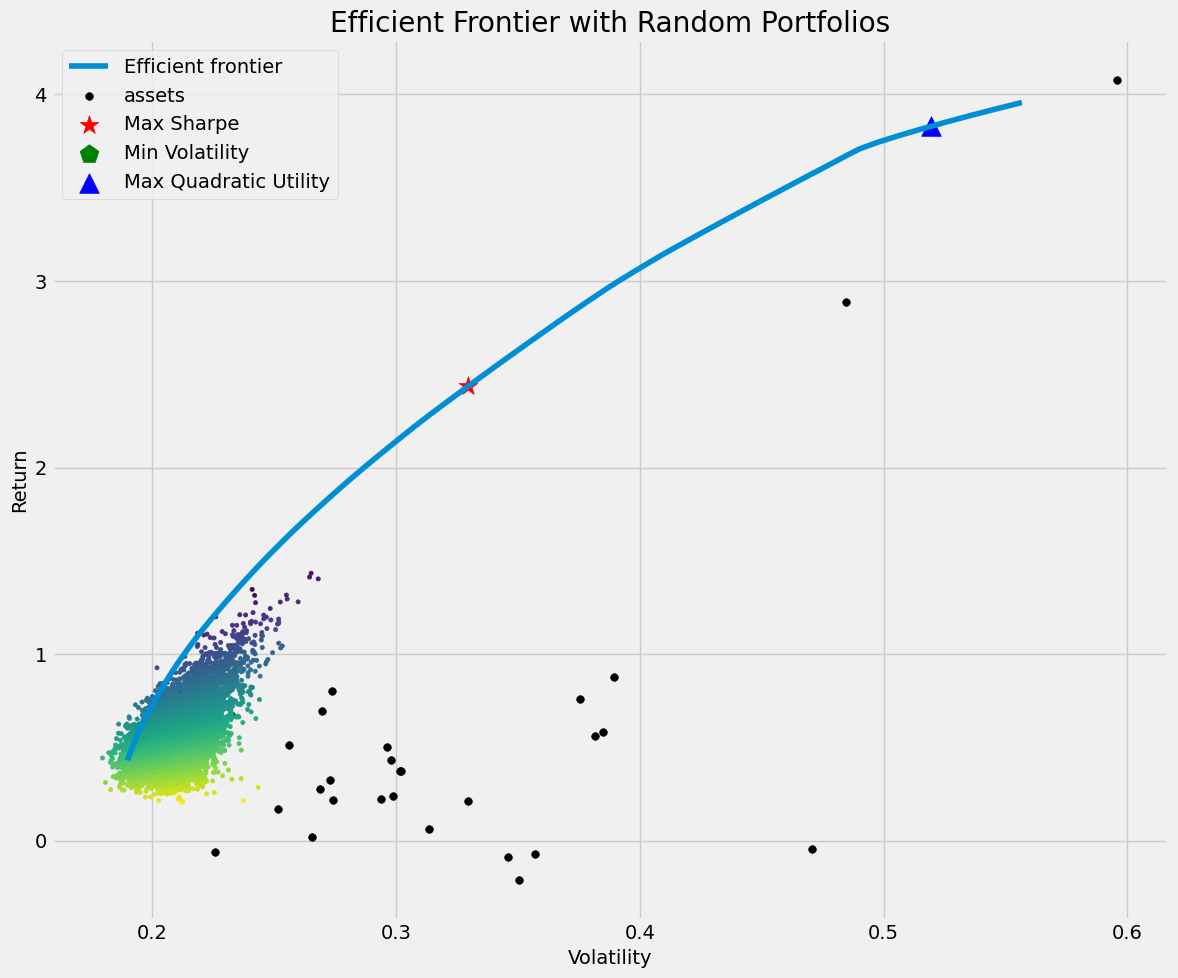

In [40]:
ut.custom_efficient_frontier(markowitz_model)

Optimize for sharpe ratio and obtain the optimal weights:

In [41]:
optimal_weights = markowitz_model.max_sharpe(risk_free_rate=rate_16m)
optimal_weights

OrderedDict([('AAPL', 0.0),
             ('AMZN', 0.0),
             ('BIIB', 0.0),
             ('CMCSA', 0.0),
             ('CME', 0.0106864605743916),
             ('COST', 0.0753654598310682),
             ('CSCO', 0.0),
             ('EA', 0.0),
             ('EBAY', 0.0267666804802603),
             ('GOOG', 0.0170380217576998),
             ('HD', 0.0245674844874768),
             ('HON', 0.0),
             ('INTC', 0.0),
             ('JPM', 0.010401588803678),
             ('LULU', 0.0564296844029374),
             ('META', 0.0),
             ('MSFT', 0.0237813422737907),
             ('NFLX', 0.0133741748262416),
             ('NVDA', 0.2464885027061358),
             ('ORLY', 0.0214849070127678),
             ('PEP', 0.01794054326802),
             ('PFE', 0.0671396409611019),
             ('PYPL', 0.0),
             ('QCOM', 0.0126921332623736),
             ('SBUX', 0.0),
             ('TSLA', 0.3758433753520563),
             ('TXN', 0.0),
             ('VRTX', 0.0),
   

In [46]:
# In sample performance
in_sample_performance = markowitz_model.portfolio_performance(risk_free_rate=rate_16m)
for metric, value in zip(['Return', 'Risk', 'Sharpe Ratio'], in_sample_performance):
    print(f'{metric}: {round(value, 4)}')

Return: 2.4946
Risk: 0.3356
Sharpe Ratio: 7.2867


In [48]:
out_sample_performance = base_optimizer.portfolio_performance(
    weights=optimal_weights,
    expected_returns=returns_models['out_sample'].to_numpy().flatten(),
    cov_matrix=risk_models['out_sample'],
    risk_free_rate=rate_16m
)
for metric, value in zip(['Return', 'Risk', 'Sharpe Ratio'], out_sample_performance):
    print(f'{metric}: {round(value, 4)}')

Return: 0.3733
Risk: 0.4353
Sharpe Ratio: 0.7448
